In [1]:
!pip install tensorflow

     |████████████████████████████████| 497.6 MB 5.4 kB/s             
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     |████████████████████████████████| 1.4 MB 28.3 MB/s            
     |████████████████████████████████| 4.3 MB 59.8 MB/s            
     |████████████████████████████████| 2.1 MB 27.2 MB/s            
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached libclang-13.0.0-py2.py3-none-manylinux1_x86_64.whl (14.5 MB)
     |████████████████████████████████| 462 kB 63.1 MB/s            
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached wrapt-1.14.0-cp39-cp39-manylinux_2_5_x86_64.manylinux

In [1]:
import tensorflow as tf 
import pathlib 
import pandas as pd 
import os
import io
import warnings
warnings.filterwarnings('ignore')
import re
import shutil
import string

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

2022-03-26 13:48:23.203086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 13:48:23.203145: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Import dataset with Pandas 
dataset = pd.read_csv("train-2.csv")
dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
dataset.shape

(7613, 5)

In [4]:
# Let's take the columns we're interested in 
clean_dataset = dataset[["id","text", "target"]]
clean_dataset.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# installation of spicy
!pip install spacy -q
!python -m spacy download en_core_web_sm -q

2022-03-26 13:48:42.373508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 13:48:42.373557: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [6]:
# loading of the model
import en_core_web_sm
nlp = en_core_web_sm.load()

In [7]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [8]:
print(STOP_WORDS)

{'please', 'move', 'indeed', 'eight', 'herein', 'was', 'bottom', 'only', 'me', 'several', 'n’t', 'became', 'show', 'seemed', 'which', 'hereafter', 'the', 'out', 'them', 'would', 'thence', 'no', 'twenty', 'almost', 'all', 'most', 'whereas', 'last', 'from', 'those', 'somewhere', 'their', 'three', 'are', 'through', 'until', 'within', 'do', 'get', 'might', 'itself', 'every', 'hereupon', 'made', 'wherein', 'except', 'him', 'hers', 'perhaps', 'nor', 'and', "'s", 'down', 'sometime', 'being', 'very', 'whom', 'did', 'if', 'along', 're', 'may', 'five', 'there', 'done', 'put', 'various', 'using', 'what', '’s', "'ve", 'another', 'name', 'we', 'after', 'go', 'two', 'towards', 'whoever', 'enough', 'than', 'own', 'under', 'behind', 'beside', 'whereby', 'least', 'namely', 'be', 'take', 'sometimes', 'i', 'something', 'everything', '’ll', 'next', 'whereafter', 'while', 'always', 'its', 'have', 'latterly', 'afterwards', 'us', 'keep', 'together', 'part', 'whose', 'nothing', 'about', 'as', 'does', 'none', 

In [9]:
#cleaning of the text
# Remove all non alphanumeric characters except whitespaces
clean_dataset["text_clean"] = clean_dataset["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
clean_dataset["text_clean"] = clean_dataset["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
clean_dataset["text_clean"] = clean_dataset["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [10]:
clean_dataset = clean_dataset[["text","text_clean","target"]]
clean_dataset

,text,text_clean,target
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive,1
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...,1
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfire evacuation order...,1
4,Just got sent this photo from Ruby #Alaska as ...,got send photo ruby alaska smoke wildfires pou...,1
...,...,...,...
7608,Two giant cranes holding a bridge collapse int...,giant crane hold bridge collapse nearby home h...,1
7609,@aria_ahrary @TheTawniest The out of control w...,ariaahrary thetawni control wild fire californ...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m194 0104 utc5 km s volcano hawaii httptcozdto...,1
7611,Police investigating after an e-bike collided ...,police investigate ebike collide car little po...,1


In [11]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000) # instanciate the tokenizer
tokenizer.fit_on_texts(clean_dataset.text_clean)
clean_dataset["review_encoded"] = tokenizer.texts_to_sequences(clean_dataset.text_clean)
clean_dataset["len_review"] = clean_dataset["review_encoded"].apply(lambda x: len(x))
clean_dataset = clean_dataset[clean_dataset["len_review"]!=0]

In [12]:
clean_dataset.head()

,text,text_clean,target,review_encoded,len_review
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive,1,"[3663, 413, 171, 1383, 1944]",5
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1,"[117, 3, 159, 511, 5547, 5548, 1014]",7
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...,1,"[1384, 446, 1706, 326, 5549, 295, 186, 1706, 3...",11
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfire evacuation order...,1,"[2301, 7, 2302, 70, 186, 283, 35]",7
4,Just got sent this photo from Ruby #Alaska as ...,got send photo ruby alaska smoke wildfires pou...,1,"[192, 179, 121, 5550, 1707, 172, 5551, 2303, 108]",9


In [17]:

#we will have to store all of our encoded texts into a single numpy array before 
#creating the tensorflow dataset. The problem is that not all our sequences are the same length, 
#this is where the tf.keras.preprocessing.sequence.pad_sequences comes in handy, 
#it will add zero padding at the end (padding="post") of your sequences so they all have equal length.

reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(clean_dataset.review_encoded, padding="post")
reviews_pad[0]

array([3663,  413,  171, 1383, 1944,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0], dtype=int32)

In [23]:
full_ds = tf.data.Dataset.from_tensor_slices((reviews_pad, clean_dataset.target.values))
full_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(25,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [24]:
#Train/test split

TAKE_SIZE = int(0.7*clean_dataset.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [25]:
# look a batch
for review, star in train_data.take(1):
  print(review, star)

tf.Tensor(
[[ 205 2894  687 ...    0    0    0]
 [ 674  549  409 ...    0    0    0]
 [  44   96 2451 ...    0    0    0]
 ...
 [ 437  204  390 ...    0    0    0]
 [ 952  537  837 ...    0    0    0]
 [ 135  194  199 ...    0    0    0]], shape=(64, 25), dtype=int32) tf.Tensor(
[0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0
 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0], shape=(64,), dtype=int64)


In [26]:
#Modeling
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[reviews_pad.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),#resuluts no relevant with relu
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="linear")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 8)             80008     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 80,297
Trainable params: 80,297
Non-trainable params: 0
____________________________________________________

In [28]:
#compilation of model
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [29]:
weights = dict(1/(clean_dataset.target).value_counts()/sum(1/(clean_dataset.target).value_counts())*5)
weights

{0: 2.1484992101105846, 1: 2.851500789889416}

In [31]:
# Entrainement du modèle 
history = model.fit(train_data, 
                    epochs=100, 
                    validation_data=test_data)

Epoch 1/100
84/84 [==============================] - 0s 3ms/step - loss: 0.0340 - mean_absolute_error: 0.1081 - val_loss: 0.2027 - val_mean_absolute_error: 0.3424
Epoch 2/100
84/84 [==============================] - 0s 3ms/step - loss: 0.0312 - mean_absolute_error: 0.0999 - val_loss: 0.2075 - val_mean_absolute_error: 0.3396
Epoch 3/100
84/84 [==============================] - 0s 3ms/step - loss: 0.0273 - mean_absolute_error: 0.0892 - val_loss: 0.2114 - val_mean_absolute_error: 0.3431
Epoch 4/100
84/84 [==============================] - 0s 3ms/step - loss: 0.0248 - mean_absolute_error: 0.0834 - val_loss: 0.2192 - val_mean_absolute_error: 0.3447
Epoch 5/100
84/84 [==============================] - 0s 3ms/step - loss: 0.0235 - mean_absolute_error: 0.0795 - val_loss: 0.2249 - val_mean_absolute_error: 0.3468
Epoch 6/100
84/84 [==============================] - 0s 3ms/step - loss: 0.0214 - mean_absolute_error: 0.0733 - val_loss: 0.2249 - val_mean_absolute_error: 0.3423
Epoch 7/100
84/84 [===

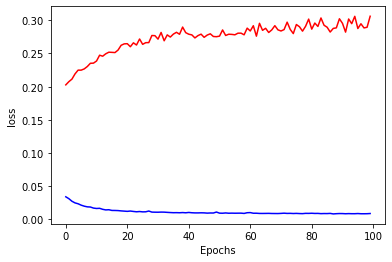

In [32]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# Conclusion (to be filled in) / Loss value O,3 / to be affined